In [1]:
import os
from scipy.io import loadmat
import pandas as pd
from GraphBuild import * 
import matplotlib.pyplot as plt
import random

### Load EVCS information

In [2]:
mat_data = loadmat('chargerdata.mat') # Reading the charging station data

In [3]:
charger_data = mat_data['chargerdata']

In [4]:
Chargers_Select = []
# Loop through each EV charger entry
for charger_name in charger_data.dtype.names:
    daily_time = charger_data[charger_name][0,0]['daily_time'][0][0].flatten()
    daily_charging_power = charger_data[charger_name][0,0]['daily_charging_power'][0][0].flatten()
    daily_charging_current = charger_data[charger_name][0,0]['daily_charging_current'][0][0].flatten()
    daily_charging_voltage = charger_data[charger_name][0,0]['daily_charging_voltage'][0][0].flatten()
    latitude = charger_data[charger_name][0,0]['Latitude'][0][0].flatten()
    longitude = charger_data[charger_name][0,0]['Longitude'][0][0].flatten()
    data = {'Latitude':latitude, 
            'Longitude':longitude, 
            'daily_charging_current':daily_charging_current,
            'daily_charging_power':daily_charging_power*5,
            'daily_charging_voltage':daily_charging_voltage,
            'daily_time': daily_time}
    Chargers_Select.append({'name':charger_name, 'data':data})

In [5]:
for d in Chargers_Select:
    d['PBase'] = (max(d['data']['daily_charging_power'])*1.05)/1000 # slighlty more than maximum and converting it to kW

In [6]:
# Charging station Info 
StationsInfo =[{'no':1, 'bus':'814', 'numphase':3, 'phaseconn':'.1.2.3', 'kV':24.9, 'kw':Chargers_Select[0]['PBase'], 'kwh':Chargers_Select[0]['PBase']*5.5*3600, 'stored':0, 'reserve':0},
               {'no':2, 'bus':'890', 'numphase':3, 'phaseconn':'.1.2.3', 'kV':4.16, 'kw':Chargers_Select[1]['PBase'], 'kwh':Chargers_Select[1]['PBase']*5.5*3600, 'stored':0, 'reserve':0},
               {'no':3, 'bus':'852', 'numphase':3, 'phaseconn':'.1.2.3', 'kV':24.9, 'kw':Chargers_Select[2]['PBase'], 'kwh':Chargers_Select[2]['PBase']*5.5*3600, 'stored':0, 'reserve':0}]

In [8]:
StationsInfo

[{'no': 1,
  'bus': '814',
  'numphase': 3,
  'phaseconn': '.1.2.3',
  'kV': 24.9,
  'kw': 368.449361198086,
  'kwh': 7295297.351722104,
  'stored': 0,
  'reserve': 0},
 {'no': 2,
  'bus': '890',
  'numphase': 3,
  'phaseconn': '.1.2.3',
  'kV': 4.16,
  'kw': 261.20449606385563,
  'kwh': 5171849.022064341,
  'stored': 0,
  'reserve': 0},
 {'no': 3,
  'bus': '852',
  'numphase': 3,
  'phaseconn': '.1.2.3',
  'kV': 24.9,
  'kw': 544.6198183458613,
  'kwh': 10783472.403248053,
  'stored': 0,
  'reserve': 0}]

## Build the Circuit

In [8]:
# Initialize Circuit
FolderName = os.path.dirname(os.path.realpath("__file__"))
DSSfile = r""+ FolderName+ "\ieee34Mod1.dss"
Ckt_obj = CircuitSetup(DSSfile, StationsInfo)  #creating a DSS object instance
G_original =  build_graph(Ckt_obj)
nx.readwrite.gml.write_gml(G_original,"34busEx.gml") #Graph undirected with edge features and node features which are constant

In [9]:
node_list=list(G_original.nodes())
edge_list=list(G_original.edges())

In [10]:
input_file = 'LoadShape1.xlsx'
sheet_name = 'LoadShape1'  # Change to the sheet you want to split
df = pd.read_excel(input_file, sheet_name=sheet_name)

points_per_day = 24  # Assuming 1-hour resolution (24 points = 24 hours)
# Convert to flat list
loadshape_values = df.iloc[:, 0].values.tolist()
# Check total number of complete days available
num_days = len(loadshape_values) // points_per_day
# Slice the loadshape into daily
LoadShapes = []
for i in range(num_days):
    start_idx = i * points_per_day
    end_idx = (i + 1) * points_per_day
    daily_shape = loadshape_values[start_idx:end_idx]
    LoadShapes.append(daily_shape)

In [11]:
# Initializing Load Demand shape
Ckt_obj.dss.Text.Command(f"New LoadShape.LoadVar")

In [12]:
# Initializing Storage Shapes
for i in range(len(StationsInfo)):
    shape_name = "StorageShape"+str(StationsInfo[i]['no'])
    Ckt_obj.dss.Text.Command(f"New LoadShape.{shape_name}")  

### Normal time series with loadshape for demand and storage

In [13]:
loadshape_day = random.choice(LoadShapes)

In [14]:
charging_profiles = []
for i in range(len(StationsInfo)):
    charge_P = -1*(Chargers_Select[i]['data']['daily_charging_power']/(StationsInfo[i]['kw']*1000)) # converting the charging power to kW, normalizing wrt to max Power and -ve (indicate charging)
    charging_profiles.append(charge_P)

In [15]:
def Powerflow_Timeseries(Ckt_obj, loadshape_day, charging_profiles):
    # Edit the LoadShape in opendss
    Ckt_obj.dss.Text.Command(f"Edit LoadShape.LoadVar npts={len(loadshape_day)} interval=1 mult=(" + ' '.join(map(str, loadshape_day)) + ")")
    # Assign Load shapes
    Ckt_obj.dss.Text.Command("BatchEdit Load..* daily=LoadVar")
    
    # Edit the Storage Shape in opendss
    for i in range(len(StationsInfo)):
        shape_name = "StorageShape"+str(StationsInfo[i]['no'])
        charge_P = charging_profiles[i]
        Ckt_obj.dss.Text.Command(f'Edit LoadShape.{shape_name} npts={len(charge_P)} pmult=({ " ".join(map(str, charge_P)) }) sinterval=1')
        # Assign Storage shapes
        elem_name = 'ChargeStatn'+str(StationsInfo[i]['no'])
        Ckt_obj.dss.Text.Command(f'Edit Storage.{elem_name} Daily={shape_name}')
          
    # Time-series simulation        
    V_node_Sc = {bus: [] for bus in node_list}
    flow_branch_Sc= {br: [] for br in edge_list}
    powers_Sc = {stations['no']:[] for stations in StationsInfo}
    states_Sc = {stations['no']:[] for stations in StationsInfo}
    
    Ckt_obj.dss.Text.Command("Set mode=daily")
    Ckt_obj.dss.Text.Command("Set stepsize=5m")
    Ckt_obj.dss.Text.Command("Set number=1")
    t= 0
    while t<24:
            Ckt_obj.dss.Solution.Solve()
            # Get Node Voltages
            for bus in node_list:
                V=Bus(Ckt_obj,bus).Vmag
                V_node_Sc[bus].append(V) 
                
            # Get Storage powers  
            i = Ckt_obj.dss.Storages.First()
            while i>0:
                    sno = StationsInfo[i-1]['no']
                    powers_Sc[sno].append(sum(Ckt_obj.dss.CktElement.Powers()[::2])) # Circuit element power 
                    states_Sc[sno].append(Ckt_obj.dss.Storages.State()) # Storage state 
                    i= Ckt_obj.dss.Storages.Next()       
                    
            # Get branchflows  
            for (u,v) in edge_list:
                branch_label = G_original[u][v]['Label']
                branch_device = G_original[u][v]['Device']
                branch_elem = f"{branch_device}.{branch_label}"
                branch_pflow = Branch(Ckt_obj,branch_elem).flow
                branchflow = np.sum(branch_pflow)
                flow_branch_Sc[(u,v)].append(branchflow)
                    
            t = Ckt_obj.dss.Solution.DblHour()
        
    return  V_node_Sc, powers_Sc, flow_branch_Sc, states_Sc
    

In [16]:
V_node_Sc, powers_Sc, flow_branch_Sc, states_Sc = Powerflow_Timeseries(Ckt_obj, loadshape_day, charging_profiles)

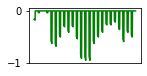

In [18]:
plt.figure(figsize=(2,1))
plt.plot(charging_profiles[2], label="Profile", color='green')
plt.xticks([]) 
plt.savefig("charging.png", dpi=300, bbox_inches='tight')

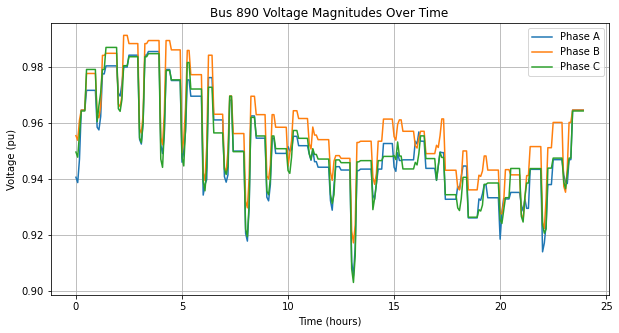

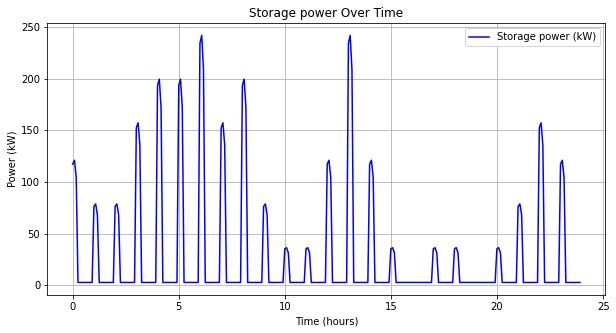

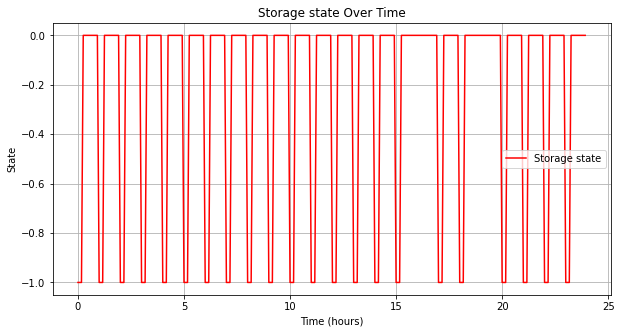

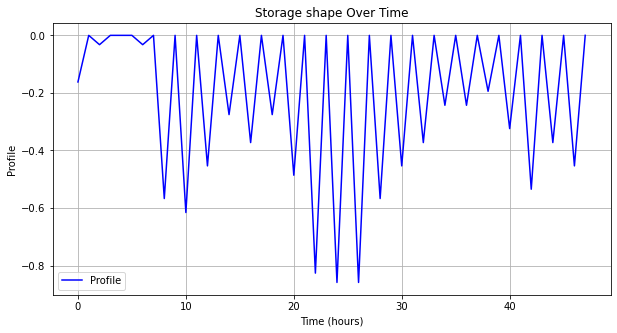

In [170]:
target_bus = '890'
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
times  =  [0.0833*t for t in range(len(V_node_Sc[target_bus]))]
Volt = V_node_Sc[target_bus]
plt.figure(figsize=(10,5))
plt.plot(times, [v[0] for v in Volt ], label="Phase A")
plt.plot(times, [v[1] for v in Volt ], label="Phase B")
plt.plot(times, [v[2] for v in Volt ], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, powers_Sc[2], label="Storage power (kW)", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("Storage power Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, states_Sc[2], label="Storage state", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Storage state Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(charging_profiles[2][::1800], label="Profile", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Profile")
plt.title("Storage shape Over Time")
plt.grid(True)
plt.legend()
plt.show()

#### Question: at 5 minute I can see variations, so now I have kept resolution at 30 m, variation in state is imperceptible. If I keep 30 m will attacks also be not observable?

In [171]:
peak_start = 9
peak_end = 19

### Type 1 attack

In [174]:
# Select Storages(s) which are under attack
num_attacked = random.randint(1, len(StationsInfo)) # no. of PVs under attack
attacked_stations = random.sample(range(len(StationsInfo)), k=num_attacked) # index of attacked PVs

In [175]:
attacked_stations

[1, 0, 2]

In [176]:
attack_mult = random.uniform(1.01,1.05)

In [177]:
attack_mult =1.05

In [178]:
charging_profiles = []
for i in range(len(StationsInfo)):
    elem_name = 'ChargeStatn'+str(StationsInfo[i]['no'])
    charge_time = Chargers_Select[i]['data']['daily_time']
    charge_P=np.zeros(len(charge_time))
    if i in attacked_stations:
        attack_max  = StationsInfo[i]['kw']*attack_mult
        for dindx in range(len(charge_time)): #for each index of charging profile
            # If the charging time is within the attack duration (peak)
                if (charge_time[dindx] > (peak_start*3600)) and (charge_time[dindx] < (peak_end*3600)):
                    charge_P[dindx] = -1*attack_mult*(Chargers_Select[i]['data']['daily_charging_power'][dindx]/(attack_max*1000)) # converting the charging power to kW, normalizing wrt to max Power and -ve (indicate charging)
                else:
                    charge_P[dindx]=-1*(Chargers_Select[i]['data']['daily_charging_power'][dindx]/(attack_max*1000)) 

        Ckt_obj.dss.Text.Command(f"Edit Storage.{elem_name} kW={attack_max} kWrated={attack_max} model=1 Vminpu=0.1 Vmaxpu=10")
    else:
        charge_P = -1*(Chargers_Select[i]['data']['daily_charging_power']/(StationsInfo[i]['kw']*1000)) # converting the charging power to kW, normalizing wrt to max Power and -ve (indicate charging)
        Ckt_obj.dss.Text.Command(f"Edit Storage.{elem_name} kW={StationsInfo[i]['kw']} kWrated={StationsInfo[i]['kw']} model=1 Vminpu=0.1 Vmaxpu=10")    
    
    charging_profiles.append(charge_P)

In [179]:
V_node_Sc1, powers_Sc1, flow_branch_Sc1, states_Sc1 = Powerflow_Timeseries(Ckt_obj, loadshape_day, charging_profiles)

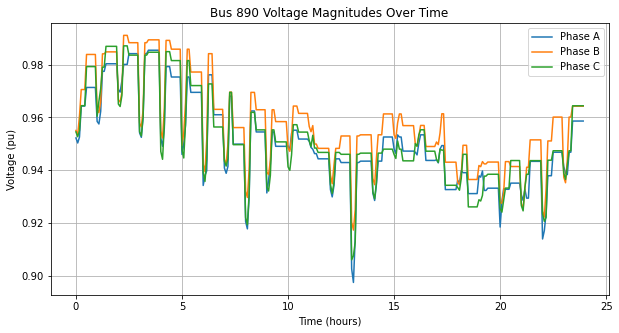

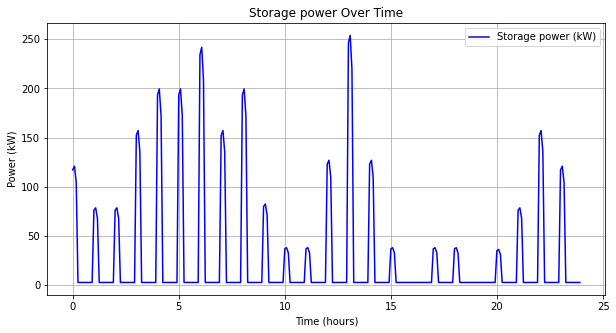

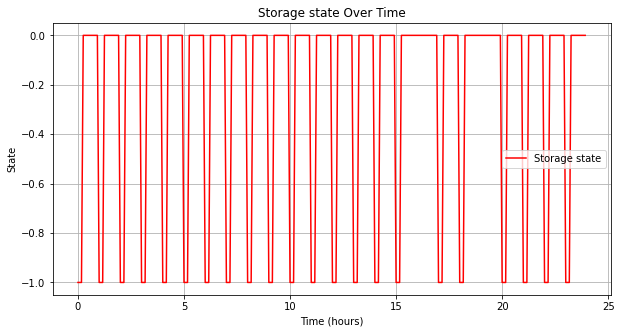

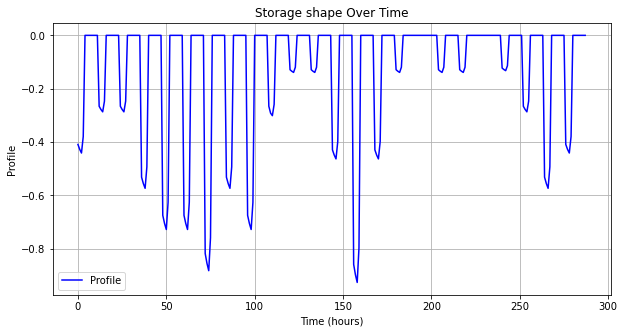

In [180]:
target_bus = '890'
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
times  =  [0.0833*t for t in range(len(V_node_Sc1[target_bus]))]
Volt = V_node_Sc1[target_bus]
plt.figure(figsize=(10,5))
plt.plot(times,[ v[0] for v in Volt ], label="Phase A")
plt.plot(times,[ v[1] for v in Volt ], label="Phase B")
plt.plot(times,[ v[2] for v in Volt ], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, powers_Sc1[2], label="Storage power (kW)", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("Storage power Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, states_Sc1[2], label="Storage state", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Storage state Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(charging_profiles[1][::300], label="Profile", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Profile")
plt.title("Storage shape Over Time")
plt.grid(True)
plt.legend()
plt.show()

### Type 2

In [25]:
time_shift = random.choice(range(1,4)) #time shift duration
shift_choice = random.choice([0,1]) #time shift direction 0: left(-ve), 1: right(+ve)
if shift_choice == 0:
    time_shift = -1*time_shift 

In [26]:
charging_profiles = []
for i in range(len(StationsInfo)):
    elem_name = 'ChargeStatn'+str(StationsInfo[i]['no'])
    charge_time = Chargers_Select[i]['data']['daily_time']
    charge_P=np.zeros(len(charge_time))
    if i in attacked_stations:
        attack_max  = StationsInfo[i]['kw']*attack_mult
        for dindx in range(len(charge_time)): #for each index of charging profile
            charge_P[dindx]=-1*(Chargers_Select[i]['data']['daily_charging_power'][dindx]/(attack_max*1000))
        # Shifting the charging demand to the left or right
        charge_P[((peak_start+time_shift)*3600):((peak_end+time_shift)*3600)] = attack_mult*charge_P[(peak_start*3600):(peak_end*3600)]    
        Ckt_obj.dss.Text.Command(f"Edit Storage.{elem_name} kW={attack_max} kWrated={attack_max} model=1 Vminpu=0.1 Vmaxpu=10")
    else:
        charge_P = -1*(Chargers_Select[i]['data']['daily_charging_power']/(StationsInfo[i]['kw']*1000)) # converting the charging power to kW, normalizing wrt to max Power and -ve (indicate charging)
        Ckt_obj.dss.Text.Command(f"Edit Storage.{elem_name} kW={StationsInfo[i]['kw']} kWrated={StationsInfo[i]['kw']} model=1 Vminpu=0.1 Vmaxpu=10")    
    
    charging_profiles.append(charge_P)

In [27]:
V_node_Sc1, powers_Sc1, flow_branch_Sc1, states_Sc1 = Powerflow_Timeseries(Ckt_obj, loadshape_day, charging_profiles)

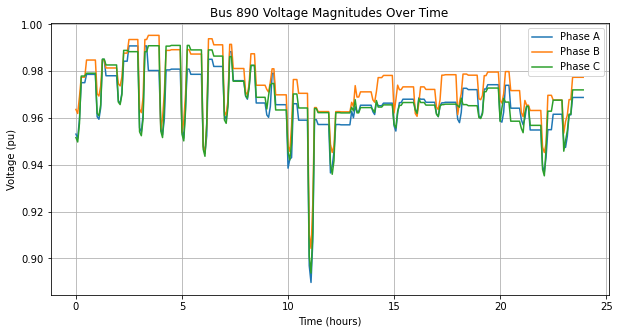

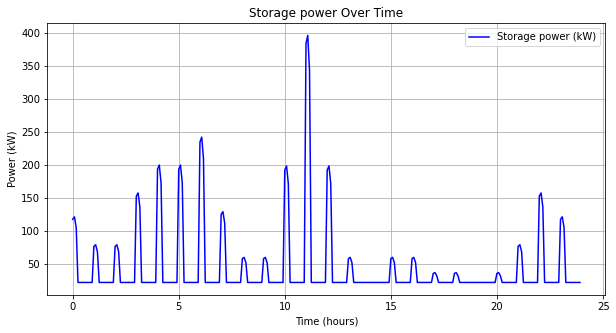

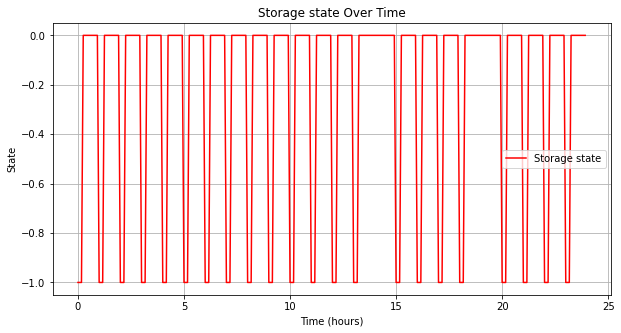

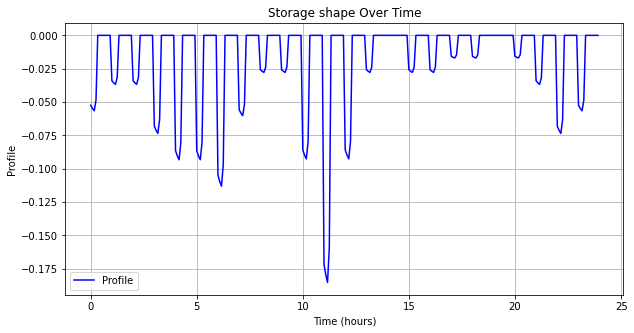

In [28]:
target_bus = '890'
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
times  =  [0.0833*t for t in range(len(V_node_Sc1[target_bus]))]
Volt = V_node_Sc1[target_bus]
plt.figure(figsize=(10,5))
plt.plot(times,[ v[0] for v in Volt ], label="Phase A")
plt.plot(times,[ v[1] for v in Volt ], label="Phase B")
plt.plot(times,[ v[2] for v in Volt ], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, powers_Sc1[2], label="Storage power (kW)", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("Storage power Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, states_Sc1[2], label="Storage state", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Storage state Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, charging_profiles[1][::300], label="Profile", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Profile")
plt.title("Storage shape Over Time")
plt.grid(True)
plt.legend()
plt.show()

### Type 3

In [29]:
charging_profiles = []
for i in range(len(StationsInfo)):
    elem_name = 'ChargeStatn'+str(StationsInfo[i]['no'])
    charge_time = Chargers_Select[i]['data']['daily_time']
    charge_P=np.zeros(len(charge_time))
    if i in attacked_stations:
        attack_max  = StationsInfo[i]['kw']*attack_mult
        for dindx in range(len(charge_time)): #for each index of charging profile
            # If the charging time is within the attack duration (peak)
                if (charge_time[dindx] > (peak_start*3600)) and (charge_time[dindx] < (peak_end*3600)):
                    charge_P[dindx] = -1*attack_mult*(Chargers_Select[i]['data']['daily_charging_power'][dindx]/(attack_max*1000)) # converting the charging power to kW, normalizing wrt to max Power and -ve (indicate charging)
                else:
                    charge_P[dindx]=-1*(Chargers_Select[i]['data']['daily_charging_power'][dindx]/(attack_max*1000)) 
        # Shifting the charging demand to the right or left
        charge_P[((peak_start+time_shift)*3600):((peak_end+time_shift)*3600)] = charge_P[(peak_start*3600):(peak_end*3600)] 

        Ckt_obj.dss.Text.Command(f"Edit Storage.{elem_name} kW={attack_max} kWrated={attack_max} model=1 Vminpu=0.1 Vmaxpu=10")
    else:
        charge_P = -1*(Chargers_Select[i]['data']['daily_charging_power']/(StationsInfo[i]['kw']*1000)) # converting the charging power to kW, normalizing wrt to max Power and -ve (indicate charging)
        Ckt_obj.dss.Text.Command(f"Edit Storage.{elem_name} kW={StationsInfo[i]['kw']} kWrated={StationsInfo[i]['kw']} model=1 Vminpu=0.1 Vmaxpu=10")    
    
    charging_profiles.append(charge_P)

In [30]:
V_node_Sc1, powers_Sc1, flow_branch_Sc1, states_Sc1 = Powerflow_Timeseries(Ckt_obj, loadshape_day, charging_profiles)

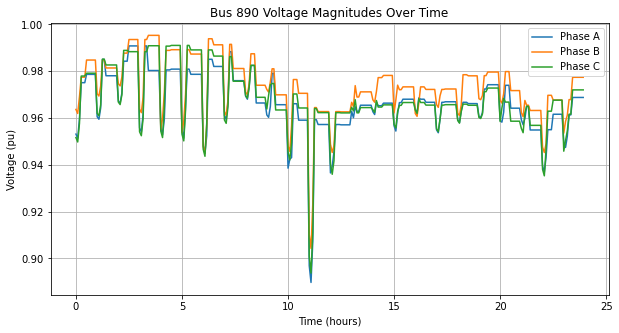

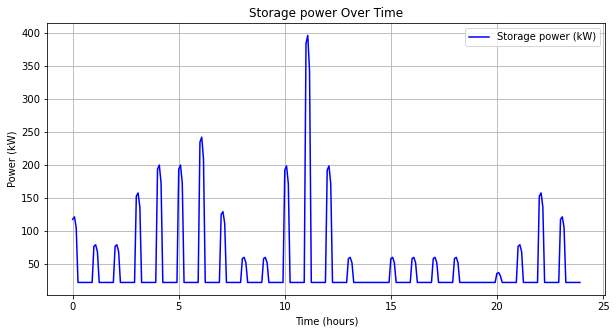

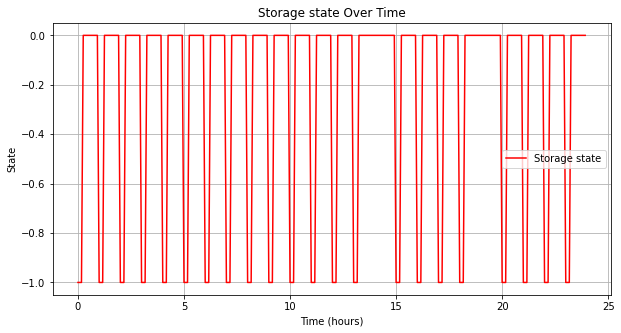

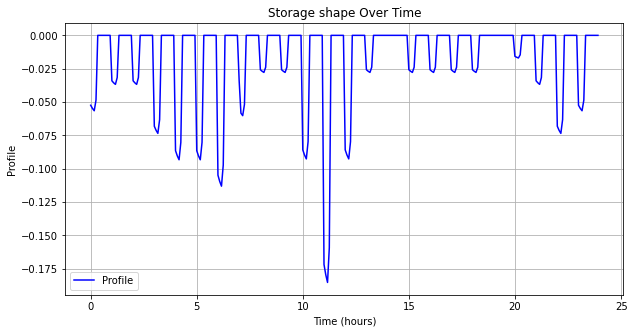

In [31]:
target_bus = '890'
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
times  =  [0.0833*t for t in range(len(V_node_Sc1[target_bus]))]
Volt = V_node_Sc1[target_bus]
plt.figure(figsize=(10,5))
plt.plot(times,[ v[0] for v in Volt ], label="Phase A")
plt.plot(times,[ v[1] for v in Volt ], label="Phase B")
plt.plot(times,[ v[2] for v in Volt ], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, powers_Sc1[2], label="Storage power (kW)", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("Storage power Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, states_Sc1[2], label="Storage state", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Storage state Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, charging_profiles[1][::300], label="Profile", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Profile")
plt.title("Storage shape Over Time")
plt.grid(True)
plt.legend()
plt.show()

### Type 4

In [32]:
attack_mult2 = random.uniform(1,2) # attack scaling factor for type 6

In [33]:
charging_profiles = []
for i in range(len(StationsInfo)):
    elem_name = 'ChargeStatn'+str(StationsInfo[i]['no'])
    charge_time = Chargers_Select[i]['data']['daily_time']
    charge_P=np.zeros(len(charge_time))
    if i in attacked_stations:
        attack_max  = StationsInfo[i]['kw']*attack_mult
        for dindx in range(len(charge_time)): #for each index of charging profile
            # If the charging time is within the attack duration (peak)
                if (charge_time[dindx] > (peak_start*3600)) and (charge_time[dindx] < (peak_end*3600)):
                    charge_P[dindx] = -1*attack_mult*(Chargers_Select[i]['data']['daily_charging_power'][dindx]/(attack_max*1000)) # converting the charging power to kW, normalizing wrt to max Power and -ve (indicate charging)
                else:
                    charge_P[dindx]=-1*(Chargers_Select[i]['data']['daily_charging_power'][dindx]/(attack_max*1000)) 
        # Shifting the charging demand to the right or left
        charge_P[((peak_start+time_shift)*3600):((peak_end+time_shift)*3600)] = attack_mult2*charge_P[(peak_start*3600):(peak_end*3600)] 

        Ckt_obj.dss.Text.Command(f"Edit Storage.{elem_name} kW={attack_max} kWrated={attack_max} model=1 Vminpu=0.1 Vmaxpu=10")
    else:
        charge_P = -1*(Chargers_Select[i]['data']['daily_charging_power']/(StationsInfo[i]['kw']*1000)) # converting the charging power to kW, normalizing wrt to max Power and -ve (indicate charging)
        Ckt_obj.dss.Text.Command(f"Edit Storage.{elem_name} kW={StationsInfo[i]['kw']} kWrated={StationsInfo[i]['kw']} model=1 Vminpu=0.1 Vmaxpu=10")    
    
    charging_profiles.append(charge_P)

In [34]:
V_node_Sc1, powers_Sc1, flow_branch_Sc1, states_Sc1 = Powerflow_Timeseries(Ckt_obj, loadshape_day, charging_profiles)

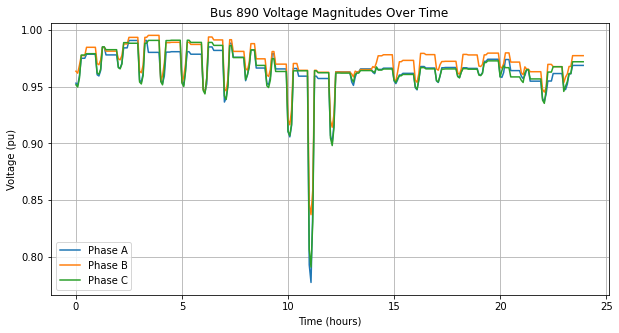

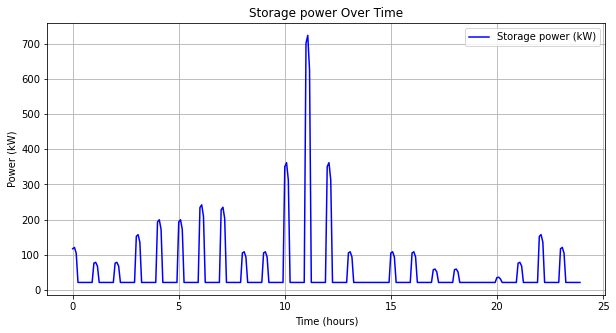

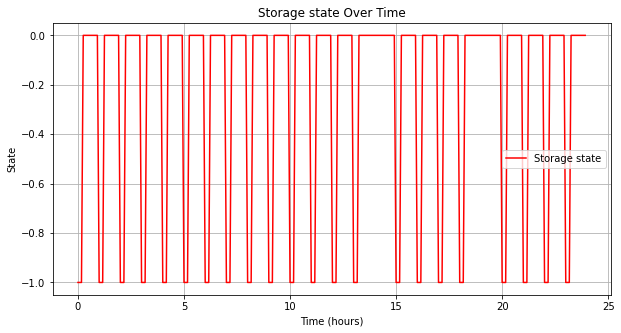

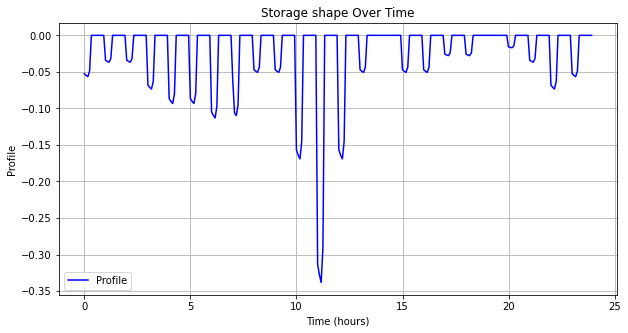

In [35]:
target_bus = '890'
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
times  =  [0.0833*t for t in range(len(V_node_Sc1[target_bus]))]
Volt = V_node_Sc1[target_bus]
plt.figure(figsize=(10,5))
plt.plot(times,[ v[0] for v in Volt ], label="Phase A")
plt.plot(times,[ v[1] for v in Volt ], label="Phase B")
plt.plot(times,[ v[2] for v in Volt ], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, powers_Sc1[2], label="Storage power (kW)", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("Storage power Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, states_Sc1[2], label="Storage state", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Storage state Over Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times, charging_profiles[1][::300], label="Profile", color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Profile")
plt.title("Storage shape Over Time")
plt.grid(True)
plt.legend()
plt.show()